# Training

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
device = torch.device("cuda")
np.random.seed(seed=33)

if True:
  deeplab_resnet101 = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

normalize3 = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalize1 = torchvision.transforms.Normalize(mean=[0.485], std=[0.229])
transforms3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize3])
transforms1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize1])

In [0]:
rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_RGB.tif')
elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/dsm_potsdam_02_10_normalized_lastools.jpg')
label_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_label.tif')

In [0]:
def transmute_to_classes(window):
  # 2 = tree
  # 3 = ground
  # 4 = clutter
  # 1 = building
  # 5 = car
  # 0 = everything else
  retval = (4*(window[:, :, 0]/0xff).astype(np.long) + 2*(window[:, :, 1]/0xff).astype(np.long) + 1*(window[:, :, 2]/0xff).astype(np.long))
  cars = (retval == 6)
  not_cars = (retval != 6)
  retval = (retval * not_cars) + 5*cars
  retval = retval * (retval < 6)
  return retval

def random_potsdam_training_window(rgb_data, elevation_data, label_data):
  size = 224
  x = np.random.randint(0, 6000 - size)
  y = np.random.randint(0, 6000 - size)
  box = (x, y, x + size, y + size)
  rgb_window = rgb_data.crop(box)
  elevation_window = elevation_data.crop(box)
  labels_window = np.array(label_data.crop(box))
  labels_window = transmute_to_classes(labels_window)
  return (rgb_window, elevation_window, labels_window)

def random_potsdam_training_batch(rgb_ar, elevation_ar, labels_ar):
  batch_size = 16
  
  rgbs = []
  elvs = []
  labs = []
  
  for i in range(batch_size):
    rgb, elv, lab = random_potsdam_training_window(rgb_ar, elevation_ar, labels_ar)

    rgbs.append(transforms3(rgb))
    elvs.append(transforms1(elv))
    labs.append(torch.unsqueeze(torch.from_numpy(lab), 0))

  rgbs = torch.stack(rgbs).to(device)
  elvs = torch.stack(elvs).to(device)
  labs = torch.cat(labs, dim=0).to(device)

  return (rgbs, elvs, labs)


In [0]:
# Reshape Network for 7 Classes

last_class = deeplab_resnet101.classifier[4] = torch.nn.Conv2d(256, 7, kernel_size=(1,1), stride=(1,1))
last_class_aux = deeplab_resnet101.aux_classifier[4] = torch.nn.Conv2d(256, 7, kernel_size=(1,1), stride=(1,1))

deeplab_resnet101 = deeplab_resnet101.to(device)

In [0]:
# Feature Extraction Only

if False:
  for p in deeplab_resnet101.parameters():
    p.requires_grad = False

  for p in last_class.parameters():
    p.requires_grad = True

  for p in last_class_aux.parameters():
    p.requires_grad = True


In [0]:
# Optimizer

ps = []
for n, p in deeplab_resnet101.named_parameters():
  if p.requires_grad == True:
    ps.append(p)
    
opt = torch.optim.SGD(ps, lr=0.01, momentum=0.9)

In [0]:
# Objective Function

obj = torch.nn.CrossEntropyLoss().to(device)

In [0]:
# Get a Batch

if False:
  import time

  before = time.time()
  batch_tensor = random_potsdam_training_batch(rgb_data, elevation_data, label_data)
  after = time.time()
  print(after - before)

In [0]:
# Train for One Step

if False:
  opt.zero_grad()
  pred = deeplab_resnet101(batch_tensor[0])
  loss = obj(pred.get('out'), batch_tensor[2])
  loss.backward()
  opt.step()

In [0]:
# Train

import time
import math

steps_per_epoch_per_image = int((6000 * 6000) / (224 * 224 * 16))
epochs = 3

deeplab_resnet101.train()
for i in range(epochs):
  for j in range(steps_per_epoch_per_image):
    batch_tensor = random_potsdam_training_batch(rgb_data, elevation_data, label_data)
    opt.zero_grad()
    pred = deeplab_resnet101(batch_tensor[0])
    loss = obj(pred.get('out'), batch_tensor[2]) + 0.4*obj(pred.get('aux'), batch_tensor[2])
    loss.backward()
    opt.step()
  print('epoch={} time={} loss={}'.format(i, time.time(), loss.item()))

# Eval

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
device = torch.device("cuda")

if True:
  deeplab_resnet101 = torch.load('/content/gdrive/My Drive/Potsdam/deeplab_resnet101_cars.pth')

normalize3 = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalize1 = torchvision.transforms.Normalize(mean=[0.485], std=[0.229])
transforms3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize3])
transforms1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize1])

In [0]:
rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/top_potsdam_2_12_RGB.tif')
elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/dsm_potsdam_02_12_normalized_lastools.jpg')
label_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/top_potsdam_2_12_label.tif')

In [0]:
def transmute_to_classes(window):
  # 2 = tree
  # 3 = ground
  # 4 = clutter
  # 1 = building
  # 5 = car
  # 0 = everything else
  retval = (4*(window[:, :, 0]/0xff).astype(np.long) + 2*(window[:, :, 1]/0xff).astype(np.long) + 1*(window[:, :, 2]/0xff).astype(np.long))
  cars = (retval == 6)
  not_cars = (retval != 6)
  retval = (retval * not_cars) + 5*cars
  retval = retval * (retval < 6)
  return retval

def potsdam_eval_window(x, y, rgb_data, elevation_data, label_data):
  size = 1000
  x = int(x * size)
  y = int(y * size)
  box = (x, y, x + size, y + size)
  rgb_window = rgb_data.crop(box)
  elevation_window = elevation_data.crop(box)
  labels_window = np.array(label_data.crop(box))
  labels_window = transmute_to_classes(labels_window)
  return (rgb_window, elevation_window, labels_window)

def potsdam_eval_batch(x, y, rgb_ar, elevation_ar, labels_ar):
  batch_size = 1
  
  rgbs = []
  elvs = []
  labs = []
  
  for i in range(batch_size):
    rgb, elv, lab = potsdam_eval_window(x, y, rgb_ar, elevation_ar, labels_ar)

    rgbs.append(transforms3(rgb))
    elvs.append(transforms1(elv))
    labs.append(torch.unsqueeze(torch.from_numpy(lab), 0))

  rgbs = torch.stack(rgbs).to(device)
  elvs = torch.stack(elvs).to(device)
  labs = torch.cat(labs, dim=0).to(device)

  return (rgbs, elvs, labs)


In [0]:
# Get a Batch
if True:
  batch_tensor = potsdam_eval_batch(2.5, 2.5, rgb_data, elevation_data, label_data)


In [0]:
if True:
  deeplab_resnet101.eval()
  out = deeplab_resnet101(batch_tensor[0])
  out = out['out'].data.cpu().numpy()
  out.shape

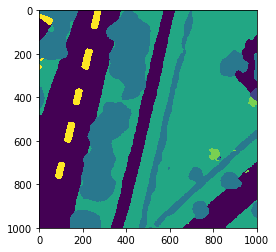

In [8]:
if True:
  index = 0
  predicted_segments = np.apply_along_axis(np.argmax, 0, out[index])
  plt.imshow(predicted_segments)

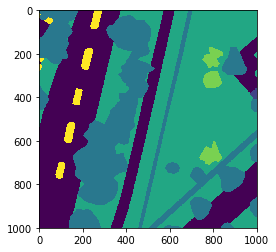

In [9]:
if True:
  index = 0
  groundtruth_segments = batch_tensor[2].data.cpu().numpy()[index]
  plt.imshow(groundtruth_segments)

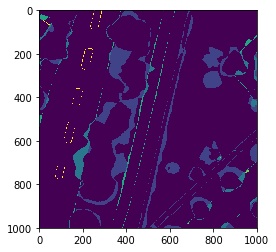

In [10]:
if True:
  plt.imshow(np.fabs(predicted_segments - groundtruth_segments))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


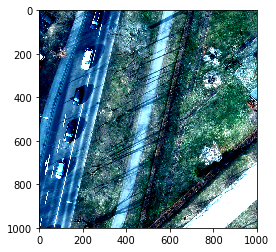

In [11]:
if True:
  img = np.transpose((batch_tensor[0][index].cpu().numpy() * 255 + 255), (1, 2, 0)).astype(int)
  plt.imshow(img)

In [12]:
tps = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fps = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fns = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

deeplab_resnet101.eval()

for x in range(6):
  for y in range(6):
      batch_tensor = potsdam_eval_batch(x, y, rgb_data, elevation_data, label_data)
      out = deeplab_resnet101(batch_tensor[0])
      out = out['out'].data.cpu().numpy()
      index = 0
      predicted_segments = np.apply_along_axis(np.argmax, 0, out[index])
      groundtruth_segments = batch_tensor[2].data.cpu().numpy()[index]
      for c in range(6):
        tps[c] += ((predicted_segments == c) * (groundtruth_segments == c)).sum()
        fps[c] += ((predicted_segments == c) * (groundtruth_segments != c)).sum()
        fns[c] += ((predicted_segments != c) * (groundtruth_segments == c)).sum()

print('True Positives:  {}'.format(tps))
print('False Negatives: {}'.format(fps))
print('False Negatives: {}'.format(fns))

True Positives:  [6230042.0, 3206532.0, 5037267.0, 17139617.0, 101643.0, 292896.0]
False Negatives: [621908.0, 163254.0, 864766.0, 2153397.0, 165685.0, 22993.0]
False Negatives: [682786.0, 365113.0, 1595735.0, 1182983.0, 132020.0, 33366.0]


In [13]:
recalls = []
precisions = []

for c in range(6):
  recall = tps[c] / (tps[c] + fns[c])
  recalls.append(recall)
  precision = tps[c] / (tps[c] + fps[c])
  precisions.append(precision)

print('Recalls:   {}'.format(recalls))
print('Precision: {}'.format(precisions))

Recalls:   [0.9012291351672571, 0.8977745548619753, 0.7594249180084673, 0.9354358551733924, 0.4349982667345707, 0.8977324971955054]
Precision: [0.9092363487766256, 0.9515536001395934, 0.8534799788479664, 0.8883846246107528, 0.3802183085946852, 0.9272117737559712]


In [15]:
names = [
    'other         ',
    'building      ',
    'tree          ',
    'low vegitation',
    'clutter       ',
    'car           '
]
f1s = []

for c in range(6):
  f1 = 2 * (precisions[c] * recalls[c]) / (precisions[c] + recalls[c])
  f1s.append(f1)
  print('{} {}'.format(names[c], f1))


other          0.9052150350699444
building       0.9238821217123673
tree           0.8037100813838972
low vegitation 0.9113033220725839
clutter        0.40576776828326255
car            0.9122340384115261


In [0]:
precision = np.array(tps).sum() / (np.array(tps).sum() + np.array(fps).sum())
recall = np.array(tps).sum() / (np.array(tps).sum() + np.array(fns).sum())
f1 = 2 * (precision * recall) / (precision + recall)

print('Overall Precision: {}'.format(precision))
print('Overall Recall:    {}'.format(recall))
print('Overall f1:        {}'.format(f1))